Exctract the signals from data for bot to read from

In [181]:
from collections import defaultdict

SIGNALS = defaultdict(lambda: {})
earliest_date = None

with open("Algo dates - Sheet1.csv") as _file:
    algo_pos = None
    actions_map = defaultdict(lambda: {})

    for i, l in enumerate(_file.readlines()):
        parts = l.replace("\n", "").split(",")
    
        if i == 0:
            algo_id = None
            algo_pos = []

            for _id in parts:
                algo_id = _id or algo_id
                algo_pos.append(algo_id)

        elif i == 1:
            for j, v in enumerate(parts):
                algo_id = algo_pos[j]
                v = v.strip()
                if v in {"Date", "Action"}:
                    actions_map[algo_id][v] = j
        else:
            for algo_id in actions_map:
                date_value = parts[actions_map[algo_id]["Date"]]
                action_value = parts[actions_map[algo_id]["Action"]]

                if date_value and action_value:
                    if not earliest_date or date_value < earliest_date:
                        earliest_date = date_value

                    SIGNALS[algo_id][date_value] = action_value.lower()

print("Earliest date: ", earliest_date)

Earliest date:  01/01/2022


Fetch data from Binance for backtesting

In [182]:
from binance import Client
import pandas as pd
import numpy as np
from itertools import product

START_DATE = "2021-12-01"
END_DATE = "2022-11-27"
TICKERS = ["BTCUSDT", "ETHUSDT"]
ASSET_TYPES = ["spot", "futures"]

client = Client()

def download(symbol, interval=Client.KLINE_INTERVAL_1DAY, futures=True):
    fn = client.futures_historical_klines if futures else client.get_historical_klines_generator
    data = fn(symbol, interval, START_DATE, END_DATE)
    df = pd.DataFrame(data, columns=[
        "open_time",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "close_time",
        "quote_volume",
        "no_of_trades",
        "taker_base_volume",
        "taker_quote_volume",
        "_"
    ])
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', utc=True)
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms', utc=True)
    c = ["Open", "High", "Low", "Close", "Volume", "quote_volume", "taker_base_volume", "taker_quote_volume"]
    df[c] = df[c].astype('float32')
    df['no_of_trades'] = df['no_of_trades'].astype('int64')
    df.set_index("open_time", inplace=True)
    return df

# Download futures and spot data
DATA_MAP = {}

for ticker, asset_type in product(TICKERS, ASSET_TYPES, repeat=1):
    DATA_MAP[(ticker, asset_type)] = download(ticker, futures=asset_type == "futures")

Previewing example data,

In [183]:
pair = next(iter(DATA_MAP))
print(pair)
DATA_MAP[pair]

('BTCUSDT', 'spot')


,Open,High,Low,Close,Volume,close_time,quote_volume,no_of_trades,taker_base_volume,taker_quote_volume,_
open_time,,,,,,,,,,,
2021-12-01 00:00:00+00:00,56950.558594,59053.550781,56458.011719,57184.070312,44956.636719,2021-12-01 23:59:59.999000+00:00,2.584929e+09,1442301,21501.294922,1.236414e+09,0
2021-12-02 00:00:00+00:00,57184.070312,57375.468750,55777.769531,56480.339844,37574.058594,2021-12-02 23:59:59.999000+00:00,2.127110e+09,1307890,18375.474609,1.040367e+09,0
2021-12-03 00:00:00+00:00,56484.261719,57600.000000,51680.000000,53601.050781,58927.691406,2021-12-03 23:59:59.999000+00:00,3.246199e+09,1865063,27287.257812,1.505557e+09,0
2021-12-04 00:00:00+00:00,53601.050781,53859.101562,42000.300781,49152.468750,114203.375000,2021-12-04 23:59:59.999000+00:00,5.495712e+09,3362771,52876.550781,2.544633e+09,0
2021-12-05 00:00:00+00:00,49152.460938,49699.050781,47727.210938,49396.328125,45580.820312,2021-12-05 23:59:59.999000+00:00,2.231486e+09,1371839,22420.902344,1.097786e+09,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23 00:00:00+00:00,16227.959961,16706.000000,16160.200195,16603.109375,264927.718750,2022-11-23 23:59:59.999000+00:00,4.368042e+09,6260616,132804.375000,2.189676e+09,0
2022-11-24 00:00:00+00:00,16603.109375,16812.630859,16458.050781,16598.949219,206565.921875,2022-11-24 23:59:59.999000+00:00,3.431724e+09,5031851,103203.320312,1.714661e+09,0
2022-11-25 00:00:00+00:00,16599.550781,16666.000000,16342.809570,16522.140625,182089.500000,2022-11-25 23:59:59.999000+00:00,3.003553e+09,4396465,90187.554688,1.487719e+09,0


### Backtest strategy

Capital: 10k USDT

Combinations:

1. Cummulative vs Fixed size (10k USDT)
2. Futures vs Spot

Assets:

1. BTC/USDT
2. ETH/USDT

In [189]:
from backtesting import Backtest, Strategy
from typing import Literal
import matplotlib.pyplot as plt
import seaborn as sns

import backtesting
backtesting.set_bokeh_output(notebook=True)
pd.options.display.max_columns = 30


CAPITAL = 10000
COMMISSION = 0
STOP_LOSS = 0.1
# Work around by multiplying capital for library to work as capital must be more than asset price. Divide by this multiplication for end-results.
MULTIPLE = 100

class AlgoBase(Strategy):

    signals = []
    mode = "cumm"

    def init(self):
        pass 

    def next(self):
        date = self.data.index[-1].strftime("%d/%m/%Y")
        price = self.data.Close[-1]
        stop_loss = (1 - STOP_LOSS) * price
        action = self.signals.get(date)

        match action:
            case "buy":
                match self.mode:
                    case "cumm":
                        self.buy(sl=stop_loss)
                    case "fixed":
                        capital = CAPITAL * MULTIPLE

                        if self.equity > capital:
                            self.buy(size=capital/self.equity, sl=stop_loss)
                        else:
                            self.buy(sl=stop_loss)
    
            case "sell":
                if self.position:
                    self.position.close()


def run_strategy(data_df, algo_id: Literal["Algo 1", "Algo 2", "Algo 3"] = "Algo 1", mode: Literal["cumm", "fixed"] = "cumm"):
    AlgoBase.signals = SIGNALS[algo_id]
    AlgoBase.mode = mode

    bt = Backtest(data_df, AlgoBase, cash=CAPITAL * MULTIPLE, commission=COMMISSION, exclusive_orders=True)
    data = bt.run()
    # Unable to plot use seaborn instead
    # bt.plot(resample=False)

    trades = data["_trades"]
    equity = data["_equity_curve"]
    data.pop("_trades")
    data.pop("_strategy")
    data.pop("_equity_curve")

    # Convert to actual capital value
    data["Equity Final [$]"] /= MULTIPLE
    data["Equity Peak [$]"] /= MULTIPLE
    data["Mode"] = mode
    data["Strategy"] = algo_id
    trades["PnL"] /= MULTIPLE

    return data, equity


def run_for_algos(symbol, asset_type):
    data_df = DATA_MAP[(symbol, asset_type)]
    results_df = []
    total_stats = []

    print(f"===== Symbol: {symbol}, Asset type: {asset_type} =====")

    for algo_id, mode in product(iter(SIGNALS), ["cumm", "fixed"]):
        stats, ec = run_strategy(data_df.copy(), algo_id, mode)
        total_stats.append(stats)
        results_df.append(ec[["Equity"]].rename({"Equity": f"{algo_id} ({mode})"}, axis=1))


    fig, axs = plt.subplots(1, 1, figsize=(20, 4))
    # Calculate %
    results_df = pd.concat(results_df) / (MULTIPLE * CAPITAL)
    results_df["Buy & Hold"] = data_df["Close"] / data_df.iloc[0]["Close"]
    results_df.index.name = "DateTime"
    results_df *= 100

    sns.color_palette("bright")
    sns.lineplot(data=results_df.reset_index().melt(id_vars=["DateTime"], 
                                                    value_vars=results_df.columns,
                                                    var_name="Strategy",
                                                    value_name="Portfolio %"), x="DateTime", y="Portfolio %", hue="Strategy", ax=axs)
    
    return pd.DataFrame(total_stats).set_index(["Strategy", "Mode"]).sort_index().T

===== Symbol: BTCUSDT, Asset type: futures =====


Strategy                                   Algo 1                             \
Mode                                         cumm                      fixed   
Start                   2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00   
End                     2022-11-27 00:00:00+00:00  2022-11-27 00:00:00+00:00   
Duration                        361 days 00:00:00          361 days 00:00:00   
Exposure Time [%]                       44.198895                  44.198895   
Equity Final [$]                      8843.844166                 8914.24835   
Equity Peak [$]                      10694.311289               10694.311289   
Return [%]                             -11.561558                 -10.857517   
Buy & Hold Return [%]                  -71.293819                 -71.293819   
Return (Ann.) [%]                      -11.651561                 -10.942384   
Volatility (Ann.) [%]                   33.789725                  33.936417   
Sharpe Ratio                                  0.0                        0.0   
Sortino Ratio                                 0.0                        0.0   
Calmar Ratio                                  0.0                        0.0   
Max. Drawdown [%]                      -27.401948                 -27.401948   
Avg. Drawdown [%]                      -14.543088                 -14.543088   
Max. Drawdown Duration          291 days 00:00:00          291 days 00:00:00   
Avg. Drawdown Duration          109 days 00:00:00          109 days 00:00:00   
# Trades                                       31                         31   
Win Rate [%]                             54.83871                   54.83871   
Best Trade [%]                          13.620338                  13.620338   
Worst Trade [%]                        -10.000197                 -10.000197   
Avg. Trade [%]                          -0.426556                  -0.426556   
Max. Trade Duration              12 days 00:00:00           12 days 00:00:00   
Avg. Trade Duration               5 days 00:00:00            5 days 00:00:00   
Profit Factor                            0.921046                   0.921046   
Expectancy [%]                          -0.210942                  -0.210942   
SQN                                     -0.338493                  -0.319763   

Strategy                                   Algo 2                             \
Mode                                         cumm                      fixed   
Start                   2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00   
End                     2022-11-27 00:00:00+00:00  2022-11-27 00:00:00+00:00   
Duration                        361 days 00:00:00          361 days 00:00:00   
Exposure Time [%]                       37.292818                  37.292818   
Equity Final [$]                     11107.142641               11300.253365   
Equity Peak [$]                      12573.483105               12472.112617   
Return [%]                              11.071426                  13.002534   
Buy & Hold Return [%]                  -71.293819                 -71.293819   
Return (Ann.) [%]                       11.168122                  13.117068   
Volatility (Ann.) [%]                   42.032892                  41.387717   
Sharpe Ratio                               0.2657                   0.316931   
Sortino Ratio                            0.497068                   0.613848   
Calmar Ratio                             0.560472                    0.66798   
Max. Drawdown [%]                      -19.926291                 -19.636923   
Avg. Drawdown [%]                       -8.599735                  -7.557427   
Max. Drawdown Duration          106 days 00:00:00          101 days 00:00:00   
Avg. Drawdown Duration           40 days 00:00:00           32 days 00:00:00   
# Trades                                       18                         18   
Win Rate [%]                            55.555556                  55.555556   

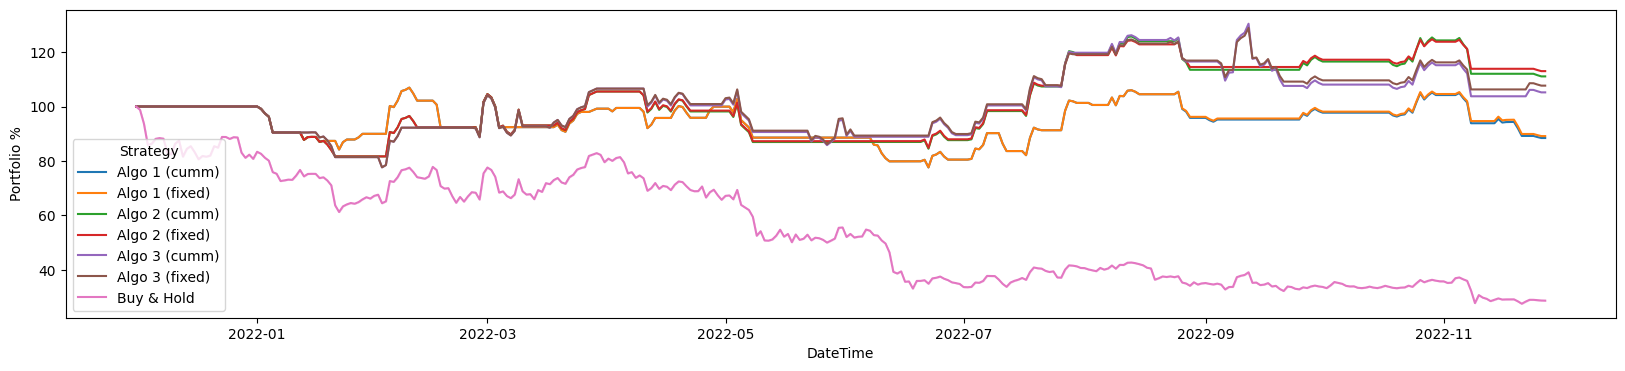

In [190]:
run_for_algos("BTCUSDT", "futures")

===== Symbol: BTCUSDT, Asset type: spot =====


Strategy                                   Algo 1                             \
Mode                                         cumm                      fixed   
Start                   2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00   
End                     2022-11-27 00:00:00+00:00  2022-11-27 00:00:00+00:00   
Duration                        361 days 00:00:00          361 days 00:00:00   
Exposure Time [%]                       44.198895                  44.198895   
Equity Final [$]                      8839.559793                8918.376441   
Equity Peak [$]                      10688.622656               10688.622656   
Return [%]                             -11.604402                 -10.816236   
Buy & Hold Return [%]                  -71.270353                 -71.270353   
Return (Ann.) [%]                      -11.694716                   -10.9008   
Volatility (Ann.) [%]                     33.7478                  33.916386   
Sharpe Ratio                                  0.0                        0.0   
Sortino Ratio                                 0.0                        0.0   
Calmar Ratio                                  0.0                        0.0   
Max. Drawdown [%]                      -27.389591                 -27.389591   
Avg. Drawdown [%]                      -14.551447                 -14.551447   
Max. Drawdown Duration          291 days 00:00:00          291 days 00:00:00   
Avg. Drawdown Duration          109 days 00:00:00          109 days 00:00:00   
# Trades                                       31                         31   
Win Rate [%]                             54.83871                   54.83871   
Best Trade [%]                          13.566018                  13.566018   
Worst Trade [%]                        -10.000022                 -10.000022   
Avg. Trade [%]                          -0.428175                  -0.428175   
Max. Trade Duration              12 days 00:00:00           12 days 00:00:00   
Avg. Trade Duration               5 days 00:00:00            5 days 00:00:00   
Profit Factor                            0.920349                   0.920349   
Expectancy [%]                          -0.212806                  -0.212806   
SQN                                     -0.339768                  -0.318701   

Strategy                                   Algo 2                             \
Mode                                         cumm                      fixed   
Start                   2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00   
End                     2022-11-27 00:00:00+00:00  2022-11-27 00:00:00+00:00   
Duration                        361 days 00:00:00          361 days 00:00:00   
Exposure Time [%]                       37.292818                  37.292818   
Equity Final [$]                     11108.002684               11301.100617   
Equity Peak [$]                      12576.697656                 12473.1625   
Return [%]                              11.080027                  13.011006   
Buy & Hold Return [%]                  -71.270353                 -71.270353   
Return (Ann.) [%]                       11.176801                  13.125619   
Volatility (Ann.) [%]                   41.970827                  41.322489   
Sharpe Ratio                             0.266299                   0.317639   
Sortino Ratio                            0.498333                   0.615462   
Calmar Ratio                             0.561868                   0.669552   
Max. Drawdown [%]                      -19.892204                 -19.603591   
Avg. Drawdown [%]                       -8.593412                  -7.556341   
Max. Drawdown Duration          112 days 00:00:00          112 days 00:00:00   
Avg. Drawdown Duration           41 days 00:00:00           33 days 00:00:00   
# Trades                                       18                         18   
Win Rate [%]                            55.555556                  55.555556   

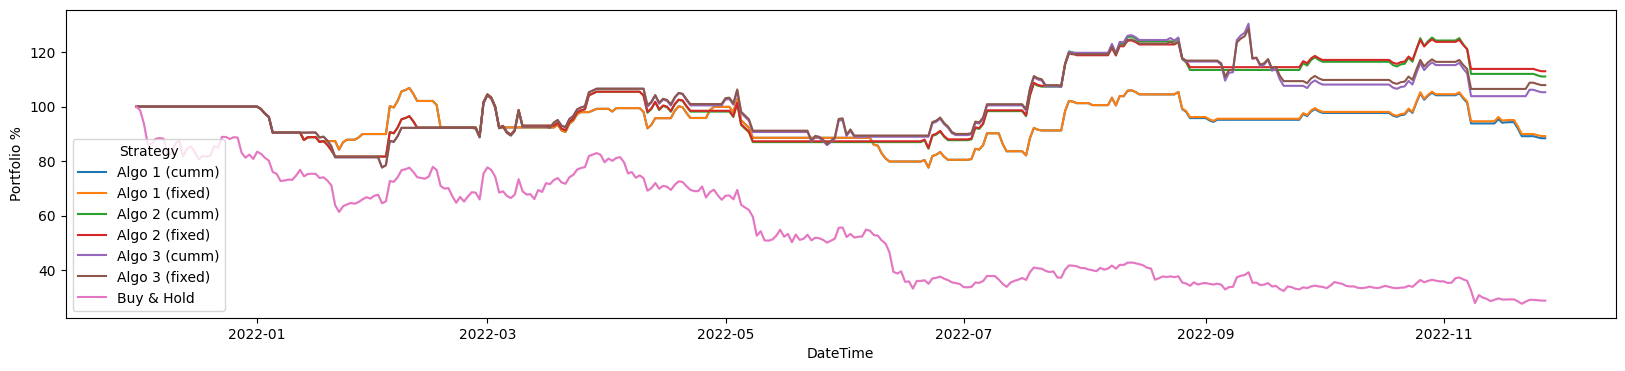

In [186]:
run_for_algos("BTCUSDT", "spot")

===== Symbol: ETHUSDT, Asset type: futures =====


Strategy                                   Algo 1                             \
Mode                                         cumm                      fixed   
Start                   2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00   
End                     2022-11-27 00:00:00+00:00  2022-11-27 00:00:00+00:00   
Duration                        361 days 00:00:00          361 days 00:00:00   
Exposure Time [%]                        41.98895                   41.98895   
Equity Final [$]                      9627.505004                10032.13354   
Equity Peak [$]                      12338.292034               12443.330837   
Return [%]                               -3.72495                   0.321335   
Buy & Hold Return [%]                  -73.984122                 -73.984122   
Return (Ann.) [%]                       -3.755233                   0.324003   
Volatility (Ann.) [%]                   52.010388                   53.51214   
Sharpe Ratio                                  0.0                   0.006055   
Sortino Ratio                                 0.0                   0.010225   
Calmar Ratio                                  0.0                   0.008199   
Max. Drawdown [%]                      -39.518366                 -39.518366   
Avg. Drawdown [%]                      -16.954616                 -16.260987   
Max. Drawdown Duration          218 days 00:00:00          218 days 00:00:00   
Avg. Drawdown Duration           66 days 00:00:00           66 days 00:00:00   
# Trades                                       31                         31   
Win Rate [%]                             45.16129                   45.16129   
Best Trade [%]                          21.371366                  21.371366   
Worst Trade [%]                        -10.000497                 -10.000497   
Avg. Trade [%]                          -0.123694                  -0.123694   
Max. Trade Duration              12 days 00:00:00           12 days 00:00:00   
Avg. Trade Duration               4 days 00:00:00            4 days 00:00:00   
Profit Factor                            1.075602                   1.075602   
Expectancy [%]                           0.264706                   0.264706   
SQN                                     -0.082065                   0.007228   

Strategy                                   Algo 2                             \
Mode                                         cumm                      fixed   
Start                   2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00   
End                     2022-11-27 00:00:00+00:00  2022-11-27 00:00:00+00:00   
Duration                        361 days 00:00:00          361 days 00:00:00   
Exposure Time [%]                       33.977901                  33.977901   
Equity Final [$]                     14142.710403               14003.985981   
Equity Peak [$]                      15972.144089               15207.142321   
Return [%]                              41.427104                   40.03986   
Buy & Hold Return [%]                  -73.984122                 -73.984122   
Return (Ann.) [%]                       41.833937                  40.431229   
Volatility (Ann.) [%]                   70.588886                  65.312346   
Sharpe Ratio                             0.592642                   0.619044   
Sortino Ratio                            1.535491                   1.609914   
Calmar Ratio                             1.370476                   1.324524   
Max. Drawdown [%]                      -30.525104                 -30.525104   
Avg. Drawdown [%]                      -10.810379                  -9.727454   
Max. Drawdown Duration          159 days 00:00:00          159 days 00:00:00   
Avg. Drawdown Duration           41 days 00:00:00           41 days 00:00:00   
# Trades                                       18                         18   
Win Rate [%]                            55.555556                  55.555556   

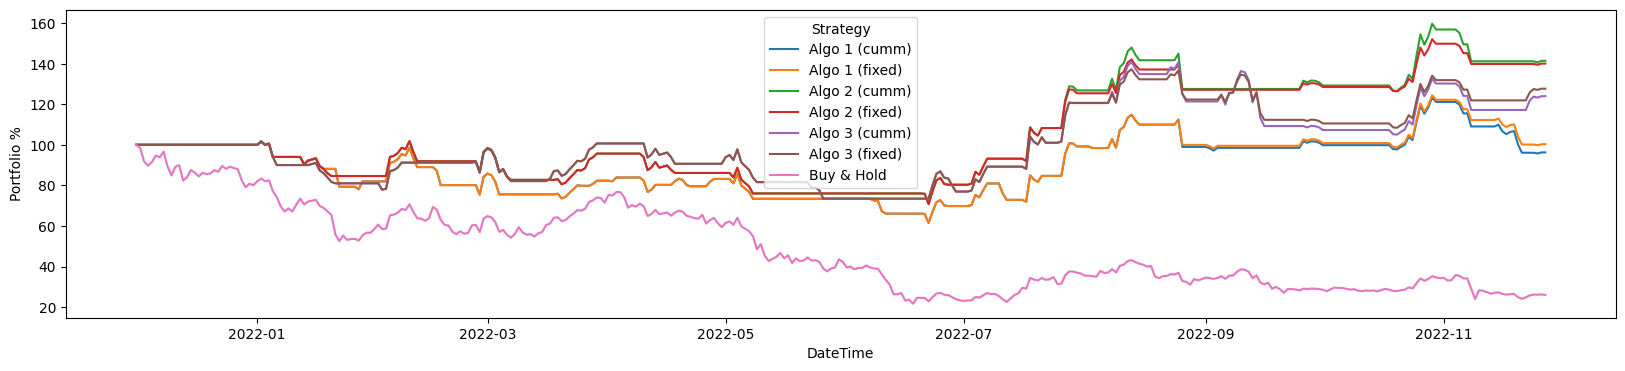

In [187]:
run_for_algos("ETHUSDT", "futures")

===== Symbol: ETHUSDT, Asset type: spot =====


Strategy                                   Algo 1                             \
Mode                                         cumm                      fixed   
Start                   2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00   
End                     2022-11-27 00:00:00+00:00  2022-11-27 00:00:00+00:00   
Duration                        361 days 00:00:00          361 days 00:00:00   
Exposure Time [%]                        41.98895                   41.98895   
Equity Final [$]                      9621.611017               10022.962501   
Equity Peak [$]                       12329.64866               12433.091468   
Return [%]                               -3.78389                   0.229625   
Buy & Hold Return [%]                  -73.949534                 -73.949534   
Return (Ann.) [%]                       -3.814642                    0.23153   
Volatility (Ann.) [%]                   51.965861                  53.457312   
Sharpe Ratio                                  0.0                   0.004331   
Sortino Ratio                                 0.0                    0.00731   
Calmar Ratio                                  0.0                   0.005866   
Max. Drawdown [%]                      -39.471021                 -39.471021   
Avg. Drawdown [%]                      -16.944373                 -16.256174   
Max. Drawdown Duration          218 days 00:00:00          218 days 00:00:00   
Avg. Drawdown Duration           66 days 00:00:00           66 days 00:00:00   
# Trades                                       31                         31   
Win Rate [%]                             45.16129                   45.16129   
Best Trade [%]                          21.342631                  21.342631   
Worst Trade [%]                        -10.000771                 -10.000771   
Avg. Trade [%]                          -0.125462                  -0.125462   
Max. Trade Duration              12 days 00:00:00           12 days 00:00:00   
Avg. Trade Duration               4 days 00:00:00            4 days 00:00:00   
Profit Factor                            1.074955                   1.074955   
Expectancy [%]                           0.262308                   0.262308   
SQN                                     -0.083455                    0.00517   

Strategy                                   Algo 2                             \
Mode                                         cumm                      fixed   
Start                   2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00   
End                     2022-11-27 00:00:00+00:00  2022-11-27 00:00:00+00:00   
Duration                        361 days 00:00:00          361 days 00:00:00   
Exposure Time [%]                       33.701657                  33.701657   
Equity Final [$]                     14126.758936               13989.852743   
Equity Peak [$]                      15957.093414               15194.289843   
Return [%]                              41.267589                  39.898527   
Buy & Hold Return [%]                  -73.949534                 -73.949534   
Return (Ann.) [%]                       41.672638                  40.288328   
Volatility (Ann.) [%]                   70.630314                  65.379665   
Sharpe Ratio                             0.590011                   0.616221   
Sortino Ratio                             1.52322                   1.596273   
Calmar Ratio                             1.365291                   1.319937   
Max. Drawdown [%]                      -30.522909                 -30.522909   
Avg. Drawdown [%]                      -10.826296                  -9.743092   
Max. Drawdown Duration          159 days 00:00:00          159 days 00:00:00   
Avg. Drawdown Duration           41 days 00:00:00           41 days 00:00:00   
# Trades                                       18                         18   
Win Rate [%]                            55.555556                  55.555556   

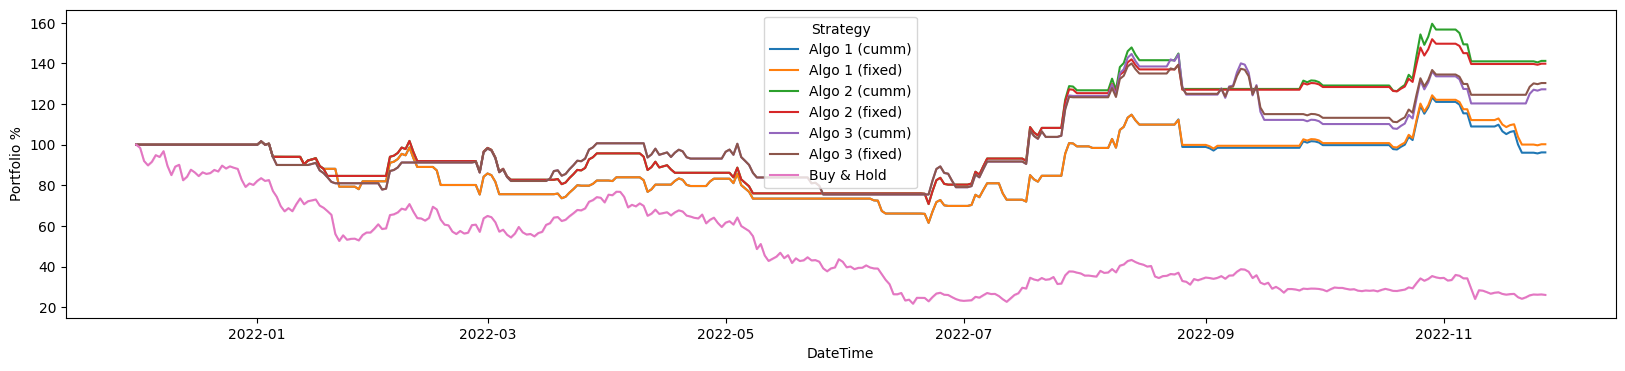

In [188]:
run_for_algos("ETHUSDT", "spot")